In [1]:
import tensorflow as tf
import numpy as np
import math
import matplotlib.pyplot as plt

def data_loader():
    (X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()
    X_train = X_train.astype(np.float32).reshape(-1, 28*28) / 255.0
    X_test = X_test.astype(np.float32).reshape(-1, 28*28) / 255.0
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)
    X_valid, X_train = X_train[:5000], X_train[5000:]
    y_valid, y_train = y_train[:5000], y_train[5000:]
    X_train2_full = X_train[y_train >= 5]
    y_train2_full = y_train[y_train >= 5] - 5
    X_valid2_full = X_valid[y_valid >= 5]
    y_valid2_full = y_valid[y_valid >= 5] - 5
    X_test2 = X_test[y_test >= 5]
    y_test2 = y_test[y_test >= 5] - 5
    
    return(X_train2_full, y_train2_full, X_valid2_full, y_valid2_full, X_test2, y_test2)


In [10]:
def shuffle_batch(xs, ys, batch_size):
    rnd_idx = np.arange(np.shape(xs)[0])
    np.random.shuffle(rnd_idx)
    return ((xs[rnd_idx[batch_size*n:batch_size*(n+1)]],ys[rnd_idx[batch_size*n:batch_size*(n+1)]])
        for n in range(0,math.floor(np.shape(xs)[0]/batch_size)))

def sample_n_instances_per_class(X, y, n):
    Xs, ys = [], []
    for label in np.unique(y):
        idx = (y==label)
        Xc = X[idx][:n]
        yc = y[idx][:n]
        Xs.append(Xc)
        ys.append(yc)
    return np.concatenate(Xs), np.concatenate(ys)

def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [35]:
def update_evaluate(X_train, y_train, X_valid, y_valid, X_test, y_test, batch_size=20, es_epochs=20, n_epochs=1000, part=2, subpart = 1):
    
    #part has 3 allowed values - '2', '3' and '4' : each corresponding to sub-questions 2.2.2, 2.2.2, 2.2.4!
    
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    best_loss = np.infty
    best_loss_acc = np.infty
    checks_without_progress = 0

    with tf.Session() as sess:

        #Restoring previous session and restoring variables values
        saver = tf.train.import_meta_graph("model.ckpt.meta")
        saver.restore(sess,tf.train.latest_checkpoint('./'))
        graph = tf.get_default_graph()
        
        #with graph.as_default():
        saver1 = tf.train.Saver()
        
        # Getting pointers to inputs, outputs and weights 
        X = graph.get_tensor_by_name("X:0")
        y = graph.get_tensor_by_name("y:0")
        weights = graph.get_tensor_by_name("hidden5/kernel:0")


        if part==2:
            output_tensor = graph.get_tensor_by_name("logits/BiasAdd:0")
            train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="logits")

        elif part==3:
            hidden4_out = graph.get_tensor_by_name("hidden4/BiasAdd:0")
            hidden4_out
            output_tensor = tf.layers.dense(hidden4_out, 5, name="out_3")
            init_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="out_3")
            sess.run(tf.initialize_variables(init_vars))
            train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="out_3")

        elif part==4:
            hidden4_out = graph.get_tensor_by_name("hidden4/BiasAdd:0")
            output_tensor = tf.layers.dense(hidden4_out, 5, name="out_4")
            init_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="out_4")
            sess.run(tf.initialize_variables(init_vars))
            train_vars = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES,scope="out_4|hidden4|hidden3")

        #for op in tf.get_default_graph().get_operations():
         #   print(op.name)

        #print(weights.eval()) #-> meant to check if we are freezing the layers or not

        # Defining accuracy, classification, loss functions and the optimizer
        def class_loss_opt(logits):
            #logits is the output layer tensor
            classification = tf.to_int32(tf.argmax(tf.nn.softmax(logits),axis=1))
            accuracy = tf.reduce_mean(tf.to_float(tf.equal(classification, y)))
            loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=logits, labels=y))
            opt2 = tf.train.AdamOptimizer(learning_rate=0.005, name = "opt2")
            training_op_2 = opt2.minimize(loss,var_list = train_vars, name = "training_op_2")
            # Initializing optimizer's variables since we aren't using the one imported from previous model.
            sess.run(tf.variables_initializer(opt2.variables()))
            return classification, accuracy, loss, training_op_2

        # Establishing operations and optimizers
        classification, accuracy, loss, training_op_2 = class_loss_opt(output_tensor)

        def collect_data(X_train,y_train,X_valid,y_valid,train_losses,train_accs,val_losses,val_accs):
            train_loss,train_acc = sess.run([loss,accuracy], feed_dict={X:X_train, y:y_train})
            val_loss,val_acc = sess.run([loss,accuracy], feed_dict={X:X_valid, y:y_valid})
            train_losses.append(train_loss)
            train_accs.append(train_acc)
            val_losses.append(val_loss)
            val_accs.append(val_acc)
            return (train_loss,train_acc,val_loss,val_acc)

        collect_data(X_train,y_train,X_valid,y_valid,train_losses,train_accs,val_losses,val_accs)

        for epoch in range(n_epochs):
            for X_batch, y_batch in shuffle_batch(X_train, y_train, batch_size):
                sess.run([training_op_2], feed_dict={X: X_batch, y: y_batch})
            train_loss,train_acc,val_loss,val_acc = collect_data(X_train,y_train,X_valid,y_valid,train_losses,train_accs,val_losses,val_accs)
            print(epoch, val_loss, val_acc)
            if val_loss < best_loss:
                save_path = saver1.save(sess, "./tf/tl_model.ckpt")
                best_train_loss = train_loss
                best_train_acc = train_acc
                best_loss = val_loss
                best_loss_acc = val_acc
            else:
                checks_without_progress += 1
                if checks_without_progress > es_epochs:
                    print("Early stopping!")
                    print(epoch, best_loss, best_loss_acc)
                    break

        saver1.restore(sess, "./tf/tl_model.ckpt")
        test_acc = sess.run([accuracy], feed_dict={X:X_test, y:y_test})
        print("Final training and validation losses:", train_losses[-1], val_losses[-1])
        print("Best network training and validation losses:", best_train_loss, best_loss)
        print("Best network training and validation accuracies:", best_train_acc, best_loss_acc)
        print("Test accuracy:", test_acc)

        #print(weights.eval()) #-> meant to check if we are freezing the layers or not
    
    plt.figure(figsize=(10,5))

    plt.subplot(121)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Cross-entropy loss')
    plt.plot(train_losses, label='Training loss')
    plt.plot(val_losses, label='Validation loss')
    plt.legend()

    plt.subplot(122)
    plt.xlabel('Number of Epochs')
    plt.ylabel('Classification accuracy')
    plt.plot(train_accs, label='Training accuracy')
    plt.plot(val_accs, label='Validation accuracy')
    plt.ylim([0,1])
    plt.legend()

    plt.tight_layout()
    if part == 2 and subpart == 1:
        file_name = 'q2_2_'+str(part)+'_full_dataset.png'
    elif part ==2 and subpart == 2:
        file_name = 'q2_2_'+'sampled_dataset.png'
    else:
        file_name = 'q2_2_'+str(part)+'.png'
    plt.savefig(file_name)

    plt.show()
    reset_graph()


Results for 2.2.2 with full dataset: 
INFO:tensorflow:Restoring parameters from ./model.ckpt
0 1.181965 0.58026206
1 1.1730474 0.51638
2 1.1946057 0.55528253
3 1.206354 0.55077803
4 1.1477678 0.57452905
5 1.2087613 0.54299754
6 1.1175088 0.5769861
7 1.1556377 0.5687961
8 1.1805807 0.56265354
9 1.1034707 0.58353806
10 1.1283783 0.5921376
11 1.2527633 0.5675676
12 1.1090028 0.5810811
13 1.1307294 0.5421786
14 1.1018567 0.5900901
15 1.1736732 0.56060606
16 1.1679566 0.58190006
17 1.1524618 0.57452905
18 1.1911943 0.5749386
19 1.1358743 0.5831286
20 1.1978122 0.53194106
21 1.0915815 0.6113841
22 1.223647 0.5241605
23 1.1154233 0.5933661
24 1.1474116 0.5814906
25 1.1995784 0.52497953
26 1.1820807 0.53849304
27 1.1744815 0.5192465
Early stopping!
27 1.0915815 0.6113841
INFO:tensorflow:Restoring parameters from ./tf/tl_model.ckpt
Final training and validation losses: 1.1574559 1.1744815
Best network training and validation losses: 1.0848097 1.0915815
Best network training and validation accur

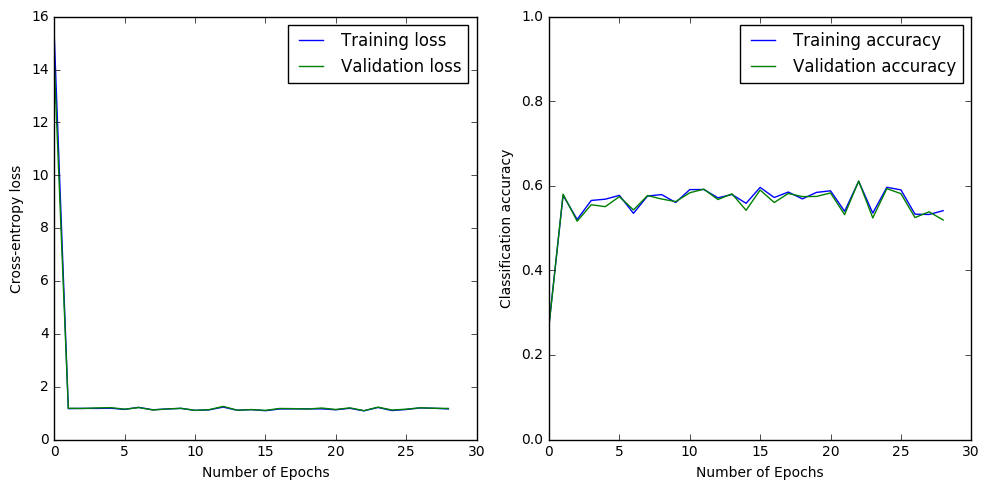

------------------------------------

Results for 2.2.2 with sampled dataset: 
INFO:tensorflow:Restoring parameters from ./model.ckpt
0 8.2788725 0.27886978
1 5.8557405 0.37182638
2 4.131909 0.38493037
3 2.860517 0.4004914
4 1.8281152 0.4946765
5 1.6374514 0.54381657
6 1.5286434 0.4954955
7 1.4765458 0.5184275
8 1.4010801 0.54135954
9 1.4759066 0.5184275
10 1.4019687 0.56101555
11 1.4079589 0.545045
12 1.3928816 0.55814904
13 1.4548854 0.53480756
14 1.4152997 0.5421786
15 1.4214805 0.56347257
16 1.4347284 0.552416
17 1.3594085 0.54095006
18 1.4215456 0.53931206
19 1.4106463 0.55446357
20 1.3737514 0.5556921
21 1.4032725 0.55159706
22 1.3636509 0.55446357
23 1.3543879 0.55282557
24 1.3638752 0.552416
25 1.3575097 0.55487305
26 1.3936855 0.536036
27 1.4416167 0.5298935
28 1.3684846 0.56552005
29 1.4524562 0.52293205
30 1.3980441 0.55446357
31 1.3608869 0.55077803
32 1.4066206 0.5405405
Early stopping!
32 1.3543879 0.55282557
INFO:tensorflow:Restoring parameters from ./tf/tl_model.ckpt
Fi

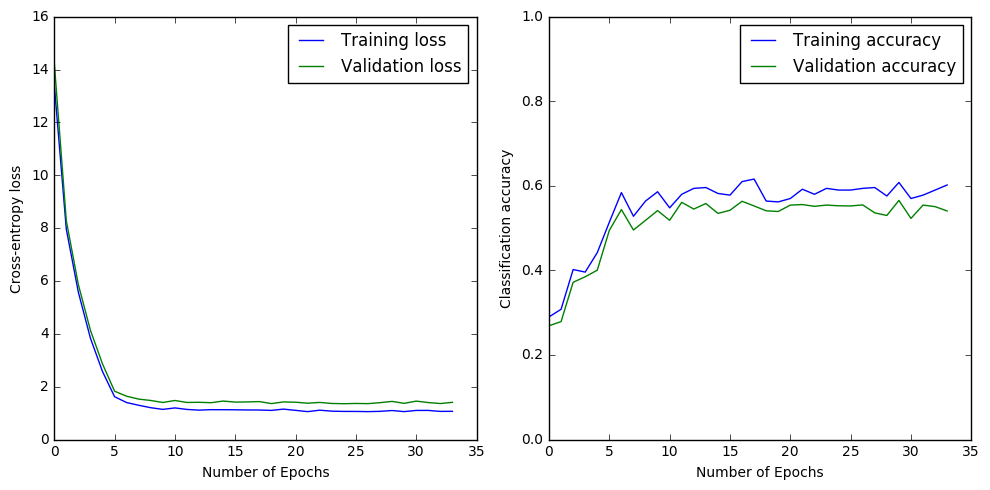

------------------------------------

Results for 2.2.3: 
INFO:tensorflow:Restoring parameters from ./model.ckpt
0 4.8824463 0.47420147
1 2.6122806 0.64332515
2 3.5248268 0.5843571
3 6.858136 0.4000819
4 8.30807 0.46355447
5 2.641235 0.63554466
6 2.7448118 0.64373463
7 3.2449403 0.6654382
8 4.4856086 0.5495495
9 6.988515 0.42219493
10 3.828089 0.62080264
11 2.9659197 0.59090906
12 5.1109905 0.5929566
13 4.003018 0.6183456
14 5.899845 0.481982
15 4.207941 0.53562653
16 3.8906133 0.56552005
17 4.3607707 0.48075348
18 2.5507493 0.5806716
19 6.6248865 0.48976249
20 4.8562164 0.504914
21 5.207721 0.43693694
22 2.6309047 0.57616705
23 6.5913386 0.6003276
Early stopping!
23 2.5507493 0.5806716
INFO:tensorflow:Restoring parameters from ./tf/tl_model.ckpt
Final training and validation losses: 6.7215767 6.5913386
Best network training and validation losses: 2.4803965 2.5507493
Best network training and validation accuracies: 0.5831541 0.5806716
Test accuracy: [0.61139685]


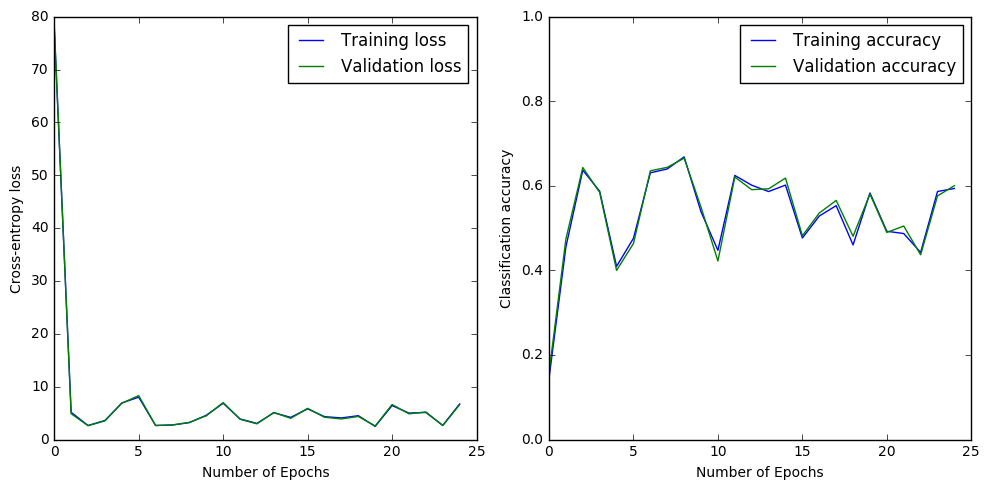

------------------------------------

Results for 2.2.4: 
INFO:tensorflow:Restoring parameters from ./model.ckpt
0 0.69149935 0.75880426
1 0.5737992 0.8104013
2 0.5016565 0.82514334
3 0.5119726 0.8259623
4 0.4491028 0.84029484
5 0.5026396 0.8407043
6 0.4322331 0.84766585
7 0.4304716 0.8558559
8 0.64049846 0.8046683
9 0.44258952 0.8394758
10 0.5059884 0.85053235
11 0.41597462 0.8587223
12 0.38846642 0.85626537
13 0.4174931 0.86240786
14 0.38847354 0.8591319
15 0.40567118 0.85708433
16 0.66035527 0.8165438
17 0.40121374 0.85954136
18 0.41964805 0.85995084
19 0.36711618 0.8783784
20 0.3946118 0.86527437
21 0.4282752 0.8587223
22 0.4107282 0.8636364
23 0.3835638 0.8710074
24 0.385701 0.8726454
25 0.38935614 0.8681409
26 0.4371417 0.85012287
27 0.40207067 0.86117935
28 0.36146754 0.87305486
29 0.4063334 0.8574939
30 0.40145695 0.86076987
Early stopping!
30 0.36146754 0.87305486
INFO:tensorflow:Restoring parameters from ./tf/tl_model.ckpt
Final training and validation losses: 0.4099307 0.401

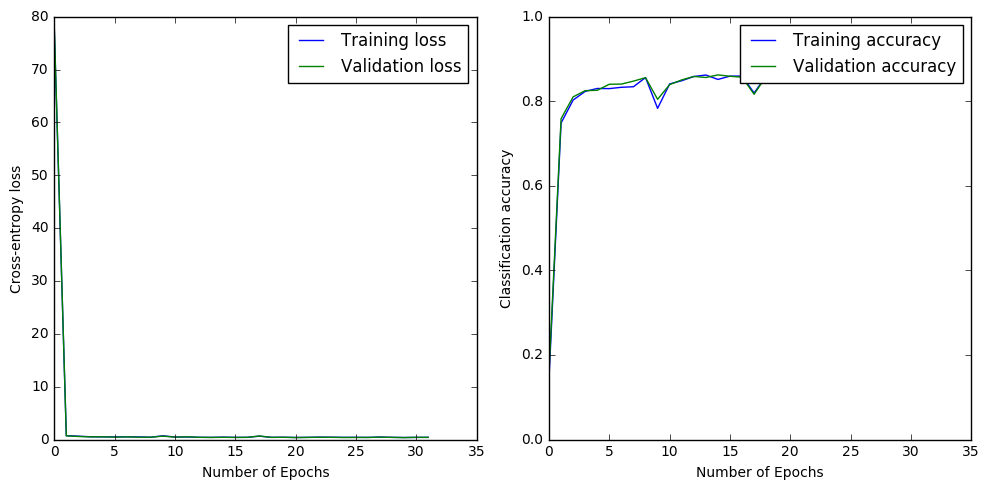

In [36]:
X_train2_full, y_train2_full, X_valid2_full, y_valid2_full, X_test, y_test = data_loader()
X_sampled, y_sampled = sample_n_instances_per_class(X_train2_full, y_train2_full, 100)

print("Results for 2.2.2 with full dataset: ") 
update_evaluate(X_train2_full, y_train2_full, X_valid2_full, y_valid2_full, X_test, y_test, part =2)

print("------------------------------------"+'\n')
print("Results for 2.2.2 with sampled dataset: ")
update_evaluate(X_sampled, y_sampled, X_valid2_full, y_valid2_full, X_test, y_test, part =2, subpart = 2)

print("------------------------------------"+'\n')
print("Results for 2.2.3: ")
update_evaluate(X_train2_full, y_train2_full, X_valid2_full, y_valid2_full, X_test, y_test, part =3)

print("------------------------------------"+'\n')
print("Results for 2.2.4: ")
update_evaluate(X_train2_full, y_train2_full, X_valid2_full, y_valid2_full, X_test, y_test, part =4)


In [18]:
reset_graph()